In [125]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

from labtools import mplplots; reload(mplplots)
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import tools as mpltools

import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.sweep import sweep, nest, chain, szip, getter, setter
from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter
from pytopo.qctools import instruments as instools

from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path

In [50]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin

In [193]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "d:/data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

In [2]:
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
ivvi = instools.create_inst(IVVI, "ivvi", "ASRL5::INSTR")

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
key1 = instools.create_inst(Keysight_34465A, "key1", "USB0::0x2A8D::0x0101::MY57503556::INSTR")
key2 = instools.create_inst(Keysight_34465A, "key2", "USB0::0x2A8D::0x0101::MY57503135::INSTR")

station = qc.Station(ivvi, key1, key2)

Initialized IVVI-rack in 0.09s
Connected to: Keysight Technologies 34465A (serial:MY57503556, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.16s
Connected to: Keysight Technologies 34465A (serial:MY57503135, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.16s


In [280]:
def smooth(x, window_len=10):
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    w = np.ones(window_len,'d')
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[int(window_len/2-1):int(-window_len/2)]


def process_data(bias, current, voltage, R, smooth_win=50, V_ratio=1e-3):    
    bias    = bias * (V_ratio/1e-3)
    voltage = voltage * 1e6
    current = current * 1e9
    voltage -= voltage.mean()
    current -= current[current.size//2]

    iof, bof = find_offset(current, bias, smooth_win=smooth_win)
    # print(iof, bof)
    bias = bias - bof
    bias -= current * R * 1e-3

    _, vof = find_offset(current, voltage, smooth_win=smooth_win)
    voltage -= vof
    # current -= iof
    print(vof)
    
    return bias, current, voltage


def find_offset(i, v, i_th=0.05, delta=1e-9, max_it=100, smooth_win=50):
    ifunc = interp1d(v, smooth(i, smooth_win), fill_value='extrapolate')
    v_guess = v[np.argmin(abs(i-i_th))] 
    # print(v_guess)
    v_pos = v_guess
    v_neg = -v_guess
    v_of = 0
    i_of = 0
    
    for k in range(max_it):
        print(k, v_of, i_of)
        
        # for each iteration:
        # 1) using current i/v offsets, find v where i exceeds the threshold (both pos and neg side)
        # 2) update the v-offset by adding the mean of the new found values to the current one
        # 3) update i-offset (just the function value of i at the new 'zero' v value)
        v_pos = fmin(lambda v: abs(ifunc(v+v_of)-i_th-i_of), v_pos, disp=0, xtol=1e-8, ftol=1e-8)
        v_neg = fmin(lambda v: abs(ifunc(v+v_of)+i_th-i_of), v_neg, disp=0, xtol=1e-8, ftol=1e-8)
        v_of_new = v_of + (v_pos+v_neg)/2.
        
        if abs(v_of - v_of_new) < delta:
            v_of = v_of_new
            i_of = ifunc(v_of)
            break

        v_of = v_of_new
        i_of = ifunc(v_of)
        
        return i_of, v_of
    

def fit_linslope(i, v, ilim=None, vlim=None):  
    if ilim is not None:
        fltr = (i>ilim[0]) & (i<ilim[1])
    elif vlim is not None:
        fltr = (v>vlim[0]) & (v<vlim[1])
    else:
        fltr = slice(None, None, None)
        
    i2 = i[fltr]
    v2 = v[fltr]
    
    p = np.polyfit(np.log(i2[i2>0]), v2[i2>0], 1)
    i_linfit = np.exp((v2-p[1])/p[0])
    T_slope = constants.e * p[0] * 1e-6 / constants.k
    
    return v2, i_linfit, T_slope

In [291]:
station.ivvi.set_dacs_zero()

In [243]:
key1.NPLC_list

[0.02, 0.06, 0.2, 1, 10, 100]

In [292]:
key1.trigger_source()

'IMM'

In [205]:
@getter([('voltage', 'V'), ('current', 'A')])
def measure_keys():
    time.sleep(0.02 * key1.NPLC()) 
    voltage = key2.volt()
    current = key1.volt()
    result = voltage/200, current * 1e-7
    return result

<IPython.core.display.Javascript object>


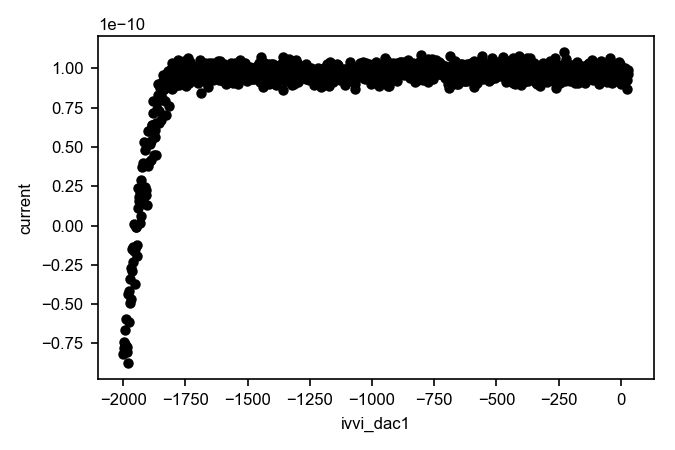

Starting experimental run with id: 16


In [ ]:
setup = [(lambda: None, tuple())]
cleanup = [(lambda: None, tuple())]

key1.NPLC(1)
key2.NPLC(1)

result = do_experiment(
#     "NIS-Thermometer/SIM_100k",
    "NIS-Thermometer/NISMar18_right",
    setup,
    sweep(ivvi.dac1, np.linspace(-2000, 2000, 2001))(
        measure_keys
    ),
    cleanup,
    return_format=["data_set_path", "dataset"], 
    live_plot_axes=[{"ivvi_dac1": 0, "current": 2}]
)

0 0 0
0 0 0
[ 1.61224044]


<IPython.core.display.Javascript object>


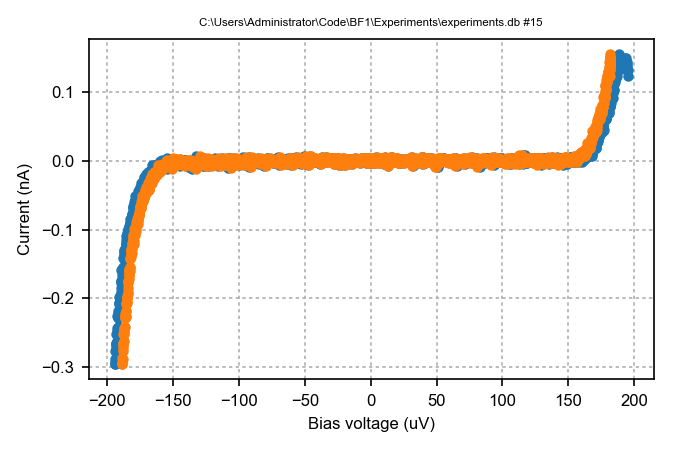

In [286]:
path, ds = result
dv = get_results_from_db_path(path)
dataid = ds.run_id


b = np.array(dv.get_values('ivvi_dac1'))[:,0]
i = np.array(dv.get_values('current'))[:,0]
v = np.array(dv.get_values('voltage'))[:,0]

R = 12e3 + 2*(5e3  + 1.7e3) * 1.

b2, i2, v2 = process_data(b, i, v, R, smooth_win=10, V_ratio=1e-4)

fig, ax = plt.subplots(1, 1)
# ax.plot((b*1e-7 - i*R) * 1e6, i * 1e9, 'o')
# ax.plot(v * 1e6, i * 1e9, 'o')
ax.plot(b2, i2, 'o')
ax.plot(v2, i2, 'o')
# ax.set_yscale('log')
ax.set_xlabel('Bias voltage (uV)')
ax.set_ylabel('Current (nA)')
# ax.set_xlim(0, None)
# ax.set_ylim(1e-4, 1)
ax.set_title(ds_title(dataid), size='x-small')
ax.grid(dashes=[2,2])
fig.tight_layout()

basepath = img_basepath(dataid)
if not os.path.exists(os.path.split(basepath)[0]):
    os.makedirs(os.path.split(basepath)[0])
fig.savefig(basepath + '.png', dpi=300)

In [287]:
# # x = (b*1e-6 - i*R * 1) * 1e6
# # y = i * 1e9
# x = v * 1e6
# y = i * 1e9
# y -= y[0:20].mean()



# fig, ax = plt.subplots(1,1)
# ax.plot(x, y, 'o')

# fitv, fiti, T = fit_linslope(y, x, vlim=(420, 450))
# ax.plot(fitv, fiti, '-')
# print(T)

# ax.set_yscale('log')
# ax.grid(dashes=[2,2])
# ax.set_xlabel('Bias voltage (uV)')
# ax.set_ylabel('Current (nA)')
# ax.set_title(ds_title(dataid), size='x-small')


# basepath = img_basepath(dataid)
# if not os.path.exists(os.path.split(basepath)[0]):
#     os.makedirs(os.path.split(basepath)[0])
# fig.savefig(basepath + 'fit_single.png', dpi=300)

<IPython.core.display.Javascript object>


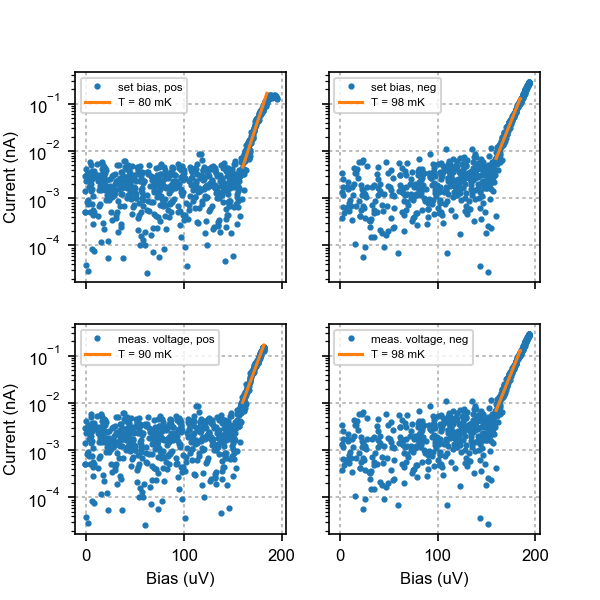

In [290]:
b_plus = b2[b2.size//2:]
b_minus = -b2[:b2.size//2]
v_plus = v2[v2.size//2:]
v_minus = -v2[:v2.size//2]
i_plus = i2[i2.size//2:]
i_minus = -i2[:i2.size//2]
labels = ['set bias, pos', 'set bias, neg', 'meas. voltage, pos', 'meas. voltage, neg']

fig, axes = plt.subplots(2, 2, figsize=(4, 4), sharex=True, sharey=True)

for i, v, ax, lbl in zip([i_plus, i_minus]*2, [b_plus, b_minus, v_plus, b_minus], axes.reshape(-1), labels):
    fitv, fiti, T = fit_linslope(i, v, vlim=(160, 185))
    ax.plot(v, i, 'o', ms=2, label=lbl)
    ax.plot(fitv, fiti, '-', label=f'T = {T*1e3:.0f} mK')
    ax.legend(loc='upper left', fontsize='x-small')
    
    ax.set_yscale('log')
    ax.grid(dashes=[2,2])
    
axes[0,0].set_ylabel('Current (nA)')
axes[1,0].set_ylabel('Current (nA)')
axes[1,0].set_xlabel('Bias (uV)')
axes[1,1].set_xlabel('Bias (uV)')

basepath = img_basepath(dataid)
if not os.path.exists(os.path.split(basepath)[0]):
    os.makedirs(os.path.split(basepath)[0])
fig.savefig(basepath + 'fit_all.png', dpi=300)